In [21]:
import numpy as np
from sklearn.calibration import calibration_curve
from matplotlib import pyplot as plt
from scipy.special import softmax


In [36]:
classes = [
    "background",
    "road",
    "sidewalk",
    "building",
    "wall",
    "fence",
    "pole",
    "traffic light",
    "traffic sign",
    "vegetation",
    "terrain",
    "sky",
    "person",
    "rider",
    "car",
    "truck",
    "bus",
    "train",
    "motorcycle",
    "bicycle",
]

In [35]:
method = np.load("CITL-291.npz")
baseline = np.load("CITL-286.npz")

method_images = method["images"]
method_predictions = method["predictions"]
method_ground_truths = method["ground_truths"]
method_predictions = softmax(method_predictions, axis=1)

baseline_images = baseline["images"]
baseline_predictions = baseline["predictions"]
baseline_ground_truths = baseline["ground_truths"]
baseline_predictions = softmax(baseline_predictions, axis=1)

In [66]:
num_images = method_images.shape[0]
num_classes = method_predictions.shape[1]

method_all_fraction_of_positives = {i: [] for i in range(1, num_classes)}
method_all_mean_predicted_value = {i: [] for i in range(1, num_classes)}

for positive_class in range(1, 20):

    for img in range(method_images.shape[0]):
        ground_truth = method_ground_truths[img].flatten()

        if positive_class not in ground_truth:
            continue
        
        method_prediction = method_predictions[img]
        probabilities_hwc = np.transpose(method_prediction, (1, 2, 0))
        flat_probabilities = probabilities_hwc.reshape(-1, probabilities_hwc.shape[-1])
        
        y_true_binary = (ground_truth == positive_class).astype(int)
        y_prob_positive = flat_probabilities[:, positive_class]
        fraction_of_positives, mean_predicted_value = calibration_curve(y_true_binary, y_prob_positive, n_bins=100)

        method_all_fraction_of_positives[positive_class].append(fraction_of_positives)
        method_all_mean_predicted_value[positive_class].append(mean_predicted_value)



In [67]:
num_images = baseline_images.shape[0]
num_classes = baseline_predictions.shape[1]

baseline_all_fraction_of_positives = {i: [] for i in range(1, num_classes)}
baseline_all_mean_predicted_value = {i: [] for i in range(1, num_classes)}

for positive_class in range(1, 20):

    for img in range(baseline_images.shape[0]):
        ground_truth = baseline_ground_truths[img].flatten()

        if positive_class not in ground_truth:
            continue
        
        baseline_prediction = baseline_predictions[img]
        probabilities_hwc = np.transpose(baseline_prediction, (1, 2, 0))
        flat_probabilities = probabilities_hwc.reshape(-1, probabilities_hwc.shape[-1])
        
        y_true_binary = (ground_truth == positive_class).astype(int)
        y_prob_positive = flat_probabilities[:, positive_class]
        fraction_of_positives, mean_predicted_value = calibration_curve(y_true_binary, y_prob_positive, n_bins=100)

        baseline_all_fraction_of_positives[positive_class].append(fraction_of_positives)
        baseline_all_mean_predicted_value[positive_class].append(mean_predicted_value)

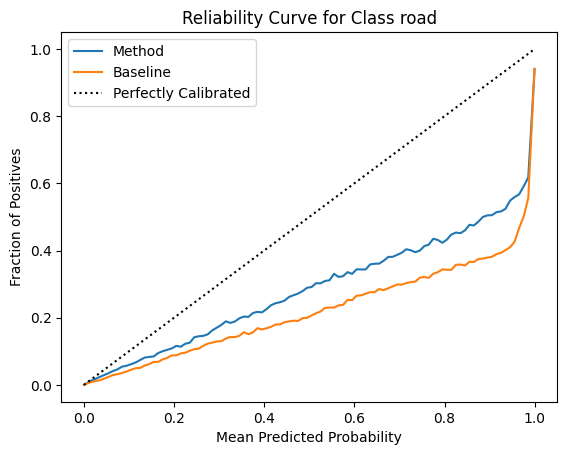

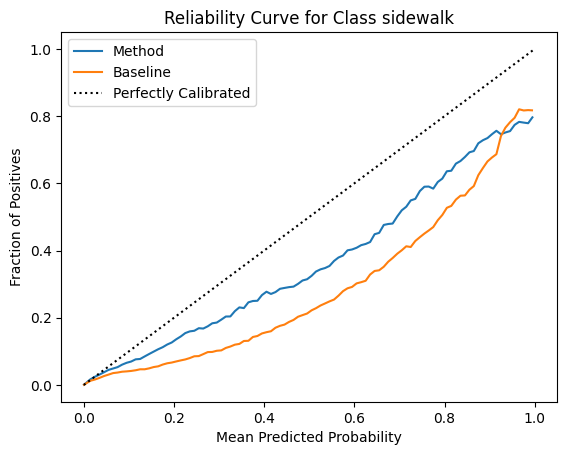

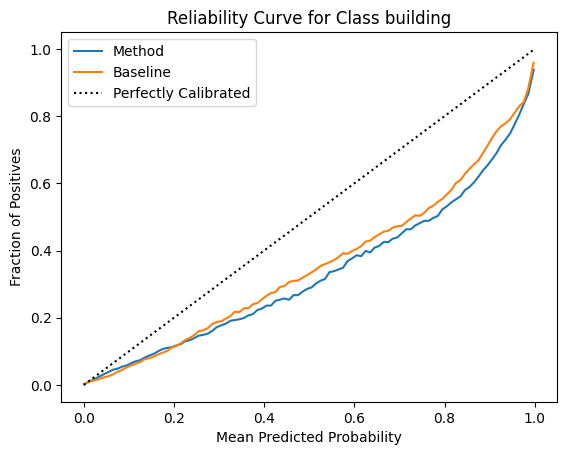

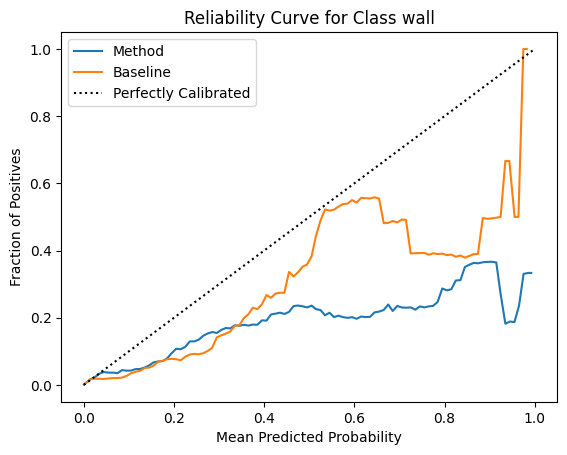

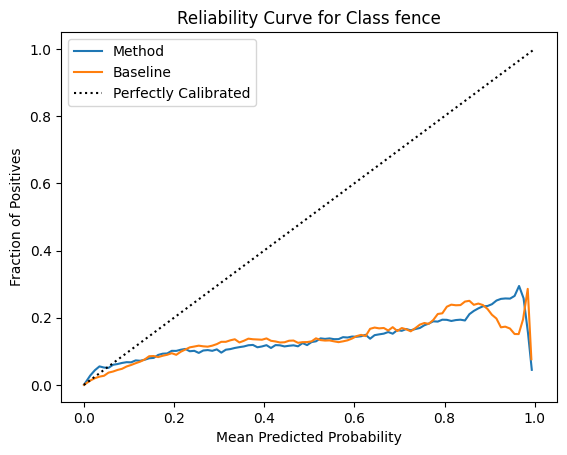

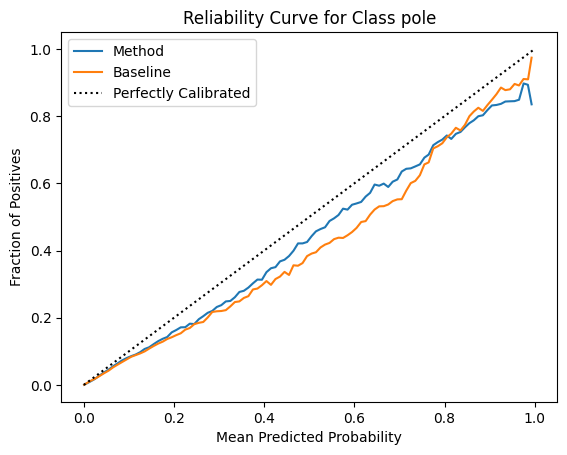

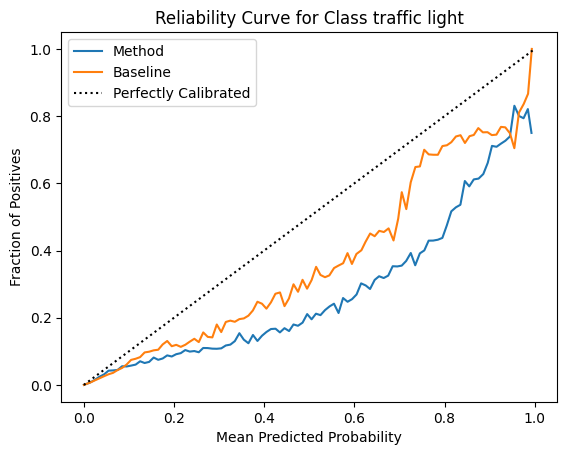

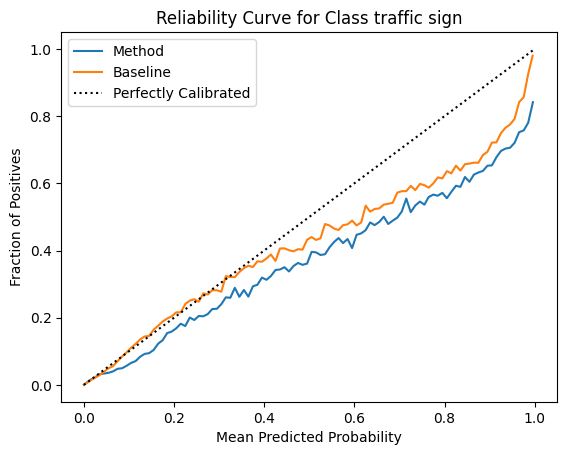

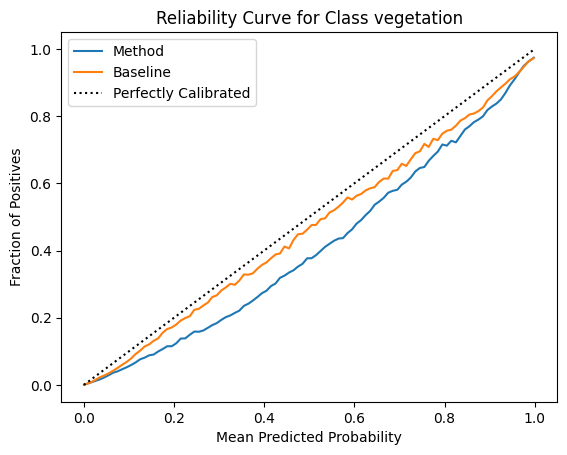

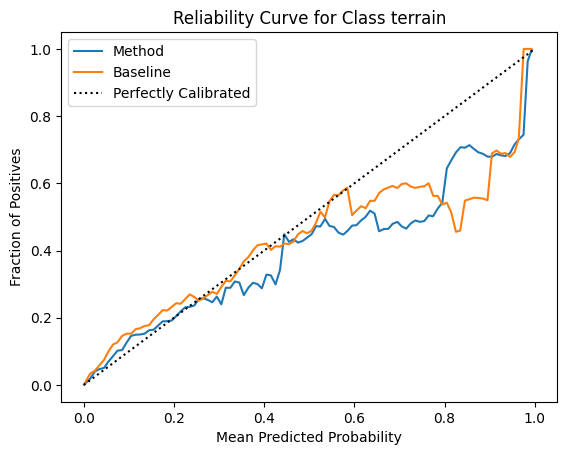

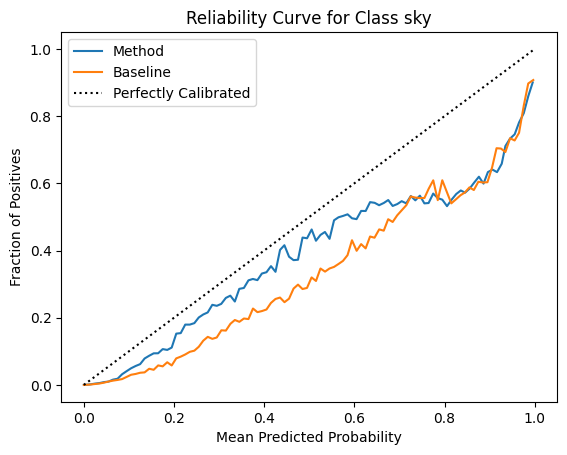

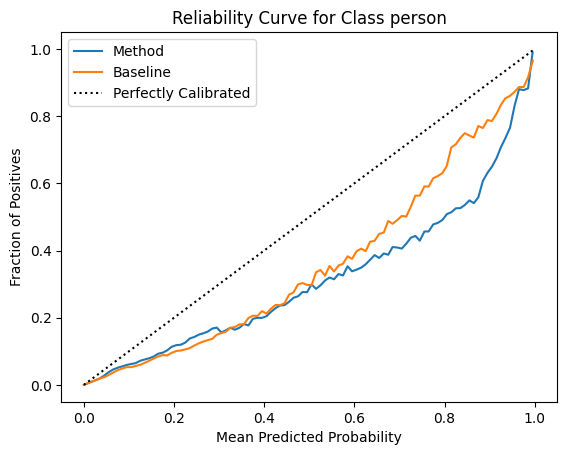

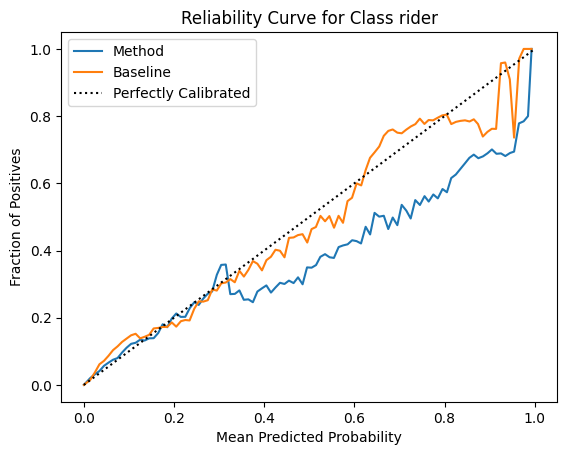

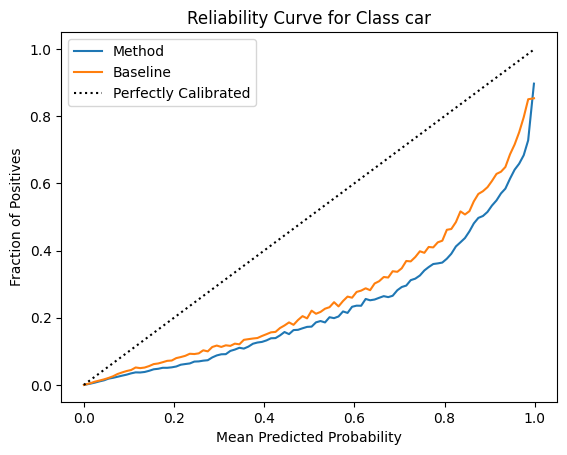

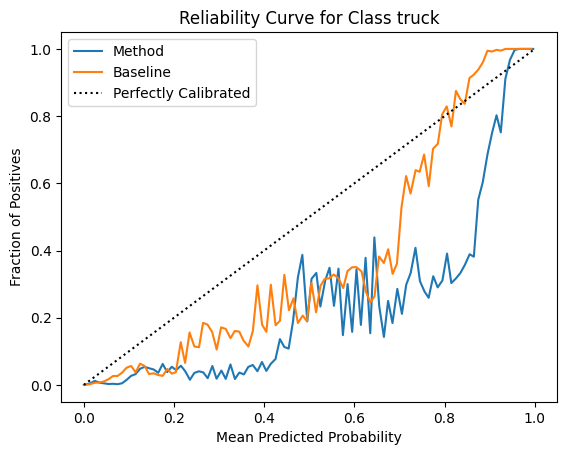

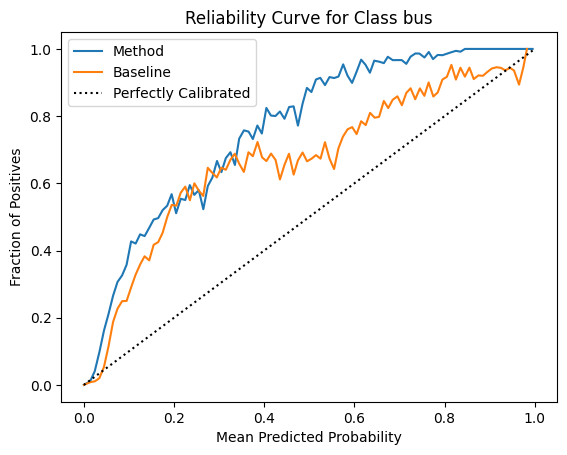

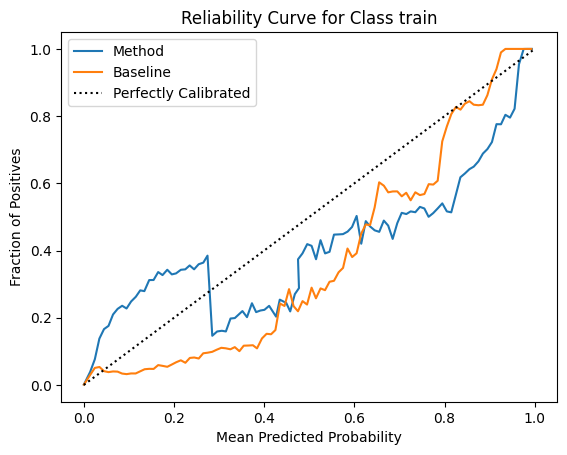

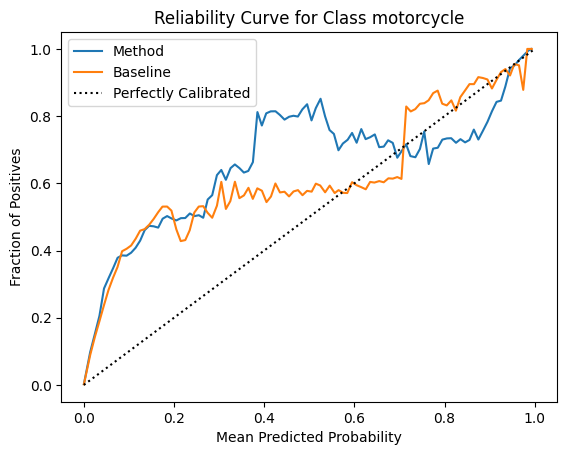

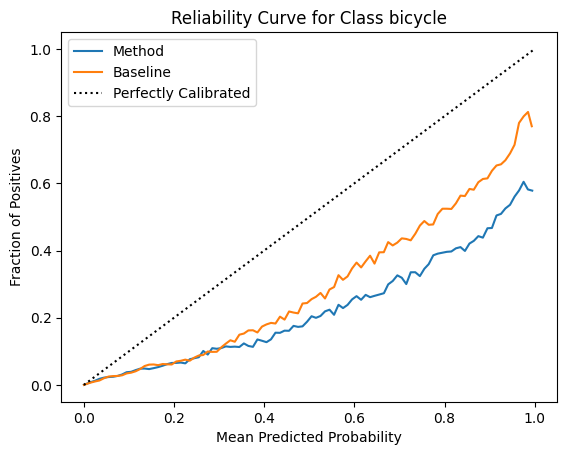

In [68]:
method_average_fraction_of_positives = {}
method_average_mean_predicted_value = {}
baseline_average_fraction_of_positives = {}
baseline_average_mean_predicted_value = {}

for positive_class in range(1, num_classes):
    # --- Average for Method ---
    if method_all_fraction_of_positives[positive_class]:
        max_len_method = max(len(arr) for arr in method_all_fraction_of_positives[positive_class])
        padded_fractions_method = [np.pad(arr, (0, max_len_method - len(arr)), constant_values=np.nan) for arr in method_all_fraction_of_positives[positive_class]]
        padded_means_method = [np.pad(arr, (0, max_len_method - len(arr)), constant_values=np.nan) for arr in method_all_mean_predicted_value[positive_class]]
        method_average_fraction_of_positives[positive_class] = np.nanmean(np.array(padded_fractions_method), axis=0)
        method_average_mean_predicted_value[positive_class] = np.nanmean(np.array(padded_means_method), axis=0)
    else:
        method_average_fraction_of_positives[positive_class] = np.array([])
        method_average_mean_predicted_value[positive_class] = np.array([])

    # --- Average for Baseline ---
    if baseline_all_fraction_of_positives[positive_class]:
        max_len_baseline = max(len(arr) for arr in baseline_all_fraction_of_positives[positive_class])
        padded_fractions_baseline = [np.pad(arr, (0, max_len_baseline - len(arr)), constant_values=np.nan) for arr in baseline_all_fraction_of_positives[positive_class]]
        padded_means_baseline = [np.pad(arr, (0, max_len_baseline - len(arr)), constant_values=np.nan) for arr in baseline_all_mean_predicted_value[positive_class]]
        baseline_average_fraction_of_positives[positive_class] = np.nanmean(np.array(padded_fractions_baseline), axis=0)
        baseline_average_mean_predicted_value[positive_class] = np.nanmean(np.array(padded_means_baseline), axis=0)
    else:
        baseline_average_fraction_of_positives[positive_class] = np.array([])
        baseline_average_mean_predicted_value[positive_class] = np.array([])

    # --- Plot for each class comparing method and baseline ---
    if method_average_mean_predicted_value[positive_class].size > 0 and baseline_average_mean_predicted_value[positive_class].size > 0:
        plt.figure()
        plt.plot(method_average_mean_predicted_value[positive_class], method_average_fraction_of_positives[positive_class], label=f"Method")
        plt.plot(baseline_average_mean_predicted_value[positive_class], baseline_average_fraction_of_positives[positive_class], label=f"Baseline")
        plt.plot([0, 1], [0, 1], "k:", label="Perfectly Calibrated")
        plt.xlabel("Mean Predicted Probability")
        plt.ylabel("Fraction of Positives")
        plt.title(f"Reliability Curve for Class {classes[positive_class]}")
        plt.legend()
        plt.show()
    elif method_average_mean_predicted_value[positive_class].size > 0:
        plt.figure()
        plt.plot(method_average_mean_predicted_value[positive_class], method_average_fraction_of_positives[positive_class], label=f"Method")
        plt.plot([0, 1], [0, 1], "k:", label="Perfectly Calibrated")
        plt.xlabel("Mean Predicted Probability")
        plt.ylabel("Fraction of Positives")
        plt.title(f"Reliability Curve for Class {classes[positive_class]}")
        plt.legend()
        plt.show()
    elif baseline_average_mean_predicted_value[positive_class].size > 0:
        plt.figure()
        plt.plot(baseline_average_mean_predicted_value[positive_class], baseline_average_fraction_of_positives[positive_class], label=f"Baseline")
        plt.plot([0, 1], [0, 1], "k:", label="Perfectly Calibrated")
        plt.xlabel("Mean Predicted Probability")
        plt.ylabel("Fraction of Positives")
        plt.title(f"Reliability Curve for Class {classes[positive_class]}")
        plt.legend()
        plt.show()
    else:
        print(f"Class {classes[positive_class]} not present in any images for either method or baseline. Skipping plot.")